<a href="https://colab.research.google.com/github/llfthu/kaggle-Google-Analytics-prediction/blob/master/Exploratory%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I'll use the two small datasets (train.csv and test.csv) to do some exploratory data analysis.

(Note: some plots may not be available in github; please open in Google colab to view them.)

## 1. Extract, transform and load dataframe



In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

In [ ]:
import os
os.chdir("drive/") 
!ls 

In [ ]:
import numpy as np 
import pandas as pd 
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None

In [ ]:
# read a two-row sample data

sample = pd.read_csv("kaggle/train.csv", nrows=2)
sample

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147


In [ ]:
# read full data with json converters

def load_df(csv_path='kaggle/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,converters={column: json.loads for column in JSON_COLUMNS},dtype={'fullVisitorId': 'str'},nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train = load_df()
test = load_df('kaggle/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [ ]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [ ]:
train.nunique()

channelGrouping                                           8
date                                                    366
fullVisitorId                                        714167
sessionId                                            902755
socialEngagementType                                      1
visitId                                              886303
visitNumber                                             384
visitStartTime                                       887159
device.browser                                           54
device.browserVersion                                     1
device.browserSize                                        1
device.operatingSystem                                   20
device.operatingSystemVersion                             1
device.isMobile                                           2
device.mobileDeviceBranding                               1
device.mobileDeviceModel                                  1
device.mobileInputSelector              

<br>There are many columns with only one unique value, or constant columns. Since these columns/features won't make any difference for the analysis, I'll just drop them from the dataframe. Note that I set the dropna parameter to be False since some features may contain missing value and thus have 2 unique values.<br><br>

In [ ]:
# drop columns that only have one unique value (including NA)

cnst_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1]
cnst_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [ ]:
train = train.drop(cnst_cols, axis=1)
test = test.drop(cnst_cols, axis=1)

## 2. Exploratory data analysis

### 2.1 Non-zero revenue, unique and common visitors

First I'll explore and visualize how many visitors have generated revenue above zero.<br><br>


In [ ]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
gdf = train.groupby('fullVisitorId')["totals.transactionRevenue"].sum().reset_index() # reset_index(): to make a dataframe output

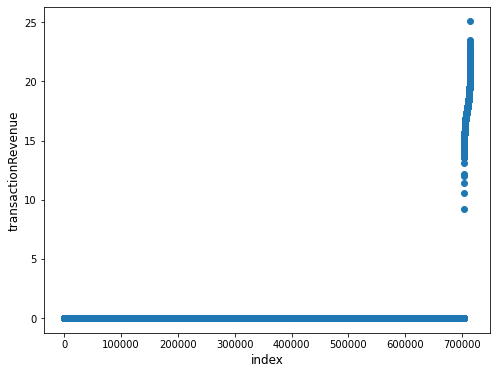

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf['totals.transactionRevenue'].values))) 
plt.xlabel('index', fontsize=12)
plt.ylabel('transactionRevenue', fontsize=12)
plt.show()

<br>Only a tiny portion of visitors generated positive revenue, and their revenues tended to be huge - log value of over 10. Therefore, our predictions are also expected to be very sparse, with most zeros and few large revenue.<br><br>

In [ ]:
n_customer = (gdf['totals.transactionRevenue']>0).sum()
n_instance = pd.notnull(train['totals.transactionRevenue']).sum()

print("Number of instances in train set with non-zero revenue : ", n_instance, " and ratio is : ", n_instance / train.shape[0])
print("Number of unique customers with non-zero revenue : ", n_customer, "and the ratio is : ", n_customer / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [ ]:
print('The number of unique visitors in train dataset is {}, out of {} rows'.format(train['fullVisitorId'].nunique(), train.shape[0]))
print('The number of unique visitors in test dataset is {}, out of {} rows'.format(test['fullVisitorId'].nunique(), test.shape[0]))

The number of unique visitors in train dataset is 714167, out of 903653 rows
The number of unique visitors in test dataset is 617242, out of 804684 rows


<br>Most visitors had only one visit session to the store.<br><br>

In [ ]:
common_visitors = set(train['fullVisitorId'].unique()).intersection(set(test['fullVisitorId'].unique()))
print('The number of common visitors in train and test dataset is {}'.format(len(common_visitors)))

The number of common visitors in train and test dataset is 7679


<br>1% visitors were common in both datasets, which means they had returned over time. Since for the prediction problem, no other information of those visitors during the time period for prediction is available beyond their visitorId, I'll need to predict the revenue based on whether these visitors return or not. In other words, I should combine classification and regression models to solve this.<br><br>


### 2.2 Explore features


I'll explore the relationship between some features (mostly categorical) and transaction revenue by visualizing the total visits, non-zero revenue visits, and mean transaction revenue by top 10 counts of each feature. To minimize repetition in this process, I'll define two functions to get aggregated features and to get a subplot.<br><br>

In [ ]:
import plotly.express as px

blues = px.colors.sequential.Blues
greens = px.colors.sequential.Greens
peach = px.colors.sequential.Peach
purples = px.colors.sequential.Purples

In [ ]:
def grouped_df(column): # get a dataframe of aggregated features
    gdf = train.groupby(column)['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
    gdf.columns = ['count', 'count of non-zero revenue', 'mean']
    gdf.sort_values(by='count', ascending=False, inplace=True)
    return gdf
  
def horizontal_bar_chart(gdf, color): # get a trace for plotting subplots
    trace = go.Bar(
        y=gdf.index[::-1],
        x=gdf.values[::-1],
        orientation = 'h',
        showlegend=False,
        marker=dict(
            color=color,
        )
    )
    return trace

<br>Device plots:<br><br>

In [ ]:
# Device Browser
gdf = grouped_df('device.browser')
trace1 = horizontal_bar_chart(gdf["count"].head(10), blues[3])
trace2 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), blues[3])
trace3 = horizontal_bar_chart(gdf["mean"].head(10), blues[3])

# Device Category
gdf = grouped_df('device.deviceCategory')
trace4 = horizontal_bar_chart(gdf["count"].head(10), peach[3])
trace5 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), peach[3])
trace6 = horizontal_bar_chart(gdf["mean"].head(10), peach[3])

# Operating system
gdf = grouped_df('device.operatingSystem')
trace7 = horizontal_bar_chart(gdf["count"].head(10), purples[3])
trace8 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10),purples[3])
trace9 = horizontal_bar_chart(gdf["mean"].head(10), purples[3])

fig = make_subplots(rows=3, cols=3, vertical_spacing=0.05, horizontal_spacing=0.10)
 
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

# Update xaxis properties
fig.update_xaxes(title_text="Total Visits", row=3, col=1)
fig.update_xaxes(title_text="Non-zero Revenue Visits", row=3, col=2)
fig.update_xaxes(title_text="Mean Revenue", row=3, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Browser", row=1, col=1)
fig.update_yaxes(title_text="Category", row=2, col=1)
fig.update_yaxes(title_text="OS", row=3, col=1)

fig.update_layout(height=900, width=1300, title=dict(text='Device Plots', x=0.5))
fig.show()

Some findings:

1.   For device features, the rankings of total visits, non-zero revenue visits and mean revenue among top values were roughly consistent.
2.   Firefox was the third most used browser but had the highest mean revenue of nearly three times higher than the second (Chrome).
3.   Macintosh was less often used than Windows among all visits but most non-zero revenue visits used Macintosh.
4.   Chrome OS visits had the highest mean revenue.





<br>Geography plots:<br><br>

In [ ]:
# Continent
gdf = grouped_df('geoNetwork.continent')
trace1 = horizontal_bar_chart(gdf["count"].head(10), blues[5])
trace2 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), blues[5])
trace3 = horizontal_bar_chart(gdf["mean"].head(10), blues[5])

# Sub-continent
gdf = grouped_df('geoNetwork.subContinent')
trace4 = horizontal_bar_chart(gdf["count"].head(10), greens[5])
trace5 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), greens[5])
trace6 = horizontal_bar_chart(gdf["mean"].head(10), greens[5])

# Country
gdf = grouped_df('geoNetwork.country')
trace7 = horizontal_bar_chart(gdf["count"].head(10), peach[5])
trace8 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), peach[5])
trace9 = horizontal_bar_chart(gdf["mean"].head(10), peach[5])

# Network Domain
gdf = grouped_df('geoNetwork.networkDomain')
trace10 = horizontal_bar_chart(gdf["count"].head(10), purples[5])
trace11 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), purples[5])
trace12 = horizontal_bar_chart(gdf["mean"].head(10), purples[5])

fig = make_subplots(rows=4, cols=3, vertical_spacing=0.04, horizontal_spacing=0.12)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)
fig.append_trace(trace10,4, 1)
fig.append_trace(trace11,4, 2)
fig.append_trace(trace12,4, 3)

# Update xaxis properties
fig.update_xaxes(title_text="Total Visits", row=4, col=1)
fig.update_xaxes(title_text="Non-zero Revenue Visits", row=4, col=2)
fig.update_xaxes(title_text="Mean Revenue", row=4, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Continent", row=1, col=1)
fig.update_yaxes(title_text="Subcontinent", row=2, col=1)
fig.update_yaxes(title_text="Country", row=3, col=1)
fig.update_yaxes(title_text="Network Domain", row=4, col=1)

fig.update_layout(height=1000, width=1200, title=dict(text='Geography Plots', x=0.5))
fig.show()

Some findings:


1.   Most visits came from Americas, Asia and Europe.
2.   Nearly all visits that generated non-zero revenue were from Northern America.
3.   Africa and Japan visits had the highest mean revenue among continents and countries although their number of non-zero revenue visits was nearly 0.
4.   Most visits had not-set or unknown network domain.






<br>Traffic Source plots:<br><br>




In [ ]:
# Traffic Source
gdf = grouped_df('trafficSource.source')
trace1 = horizontal_bar_chart(gdf["count"].head(10), blues[7])
trace2 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), blues[7])
trace3 = horizontal_bar_chart(gdf["mean"].head(10), blues[7])

# Medium
gdf = grouped_df('trafficSource.medium')
trace4 = horizontal_bar_chart(gdf["count"].head(10), greens[7])
trace5 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), greens[7])
trace6 = horizontal_bar_chart(gdf["mean"].head(10), greens[7])

# AdNetwork Type
gdf = grouped_df('trafficSource.adwordsClickInfo.adNetworkType')
trace7 = horizontal_bar_chart(gdf["count"].head(10), peach[6])
trace8 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), peach[6])
trace9 = horizontal_bar_chart(gdf["mean"].head(10), peach[6])

# AdContent
gdf = grouped_df('trafficSource.adContent')
trace10 = horizontal_bar_chart(gdf["count"].head(10), purples[7])
trace11 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(10), purples[7])
trace12 = horizontal_bar_chart(gdf["mean"].head(10), purples[7])

fig = make_subplots(rows=4, cols=3, vertical_spacing=0.04, horizontal_spacing=0.22)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)
fig.append_trace(trace10,4, 1)
fig.append_trace(trace11,4, 2)
fig.append_trace(trace12,4, 3)

# Update xaxis properties
fig.update_xaxes(title_text="Total Visits", row=4, col=1)
fig.update_xaxes(title_text="Non-zero Revenue Visits", row=4, col=2)
fig.update_xaxes(title_text="Mean Revenue", row=4, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Source", row=1, col=1)
fig.update_yaxes(title_text="Medium", row=2, col=1)
fig.update_yaxes(title_text="AdNetwork Type", row=3, col=1)
fig.update_yaxes(title_text="AdContent", row=4, col=1)

fig.update_layout(height=1000, width=1200, title=dict(text='Traffic Source Plots', x=0.5))
fig.show()

Some findings:
1.   Most traffic source was related to Google.
2.   dfa and cpm had the highest mean revenue among traffic sources and source mediums.





<br>Session Plots (number of hits and pageviews):<br><br>

In [ ]:
# Total Hits
gdf = grouped_df('totals.hits')
trace1 = horizontal_bar_chart(gdf["count"].head(60), blues[8])
trace2 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(60), blues[8])
trace3 = horizontal_bar_chart(gdf["mean"].head(60), blues[8])

# Total Pageviews
gdf = grouped_df('totals.pageviews')
trace4 = horizontal_bar_chart(gdf["count"].head(60), purples[8])
trace5 = horizontal_bar_chart(gdf["count of non-zero revenue"].head(60), purples[8])
trace6 = horizontal_bar_chart(gdf["mean"].head(60), purples[8])

fig = make_subplots(rows=2, cols=3, vertical_spacing=0.06, horizontal_spacing=0.08)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

# Update xaxis properties
fig.update_xaxes(title_text="Total Visits", row=2, col=1)
fig.update_xaxes(title_text="Non-zero Revenue Visits", row=2, col=2)
fig.update_xaxes(title_text="Mean Revenue", row=2, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Total Hits", row=1, col=1)
fig.update_yaxes(title_text="Total Pageviews", row=2, col=1)

fig.update_layout(height=900, width=1200, title=dict(text='Session Plots', x=0.5))
fig.show()

Some findings:


1.   These two features were highly predictive of transaction revenue.
2.   Revenue was non-zero only when hits or pageviews was above 1.
3.   With hits/pageviews increasing, non-zero revenue visits increased at first, then decreased.
4.   Most visits had less than 10 hits/pageviews.<br><br>



### 2.3 Explore time-related features

For time-related features, I'll mainly explore two parts: 1) the seasonality of visits and mean revenue; 2) two aggregated features (datediff, total visit) and their relation to revenue.

<br>**Seasonality of visits and mean revenue:**<br><br>

In [ ]:
# datetype conversion
train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')

In [ ]:
gdf = train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
gdf.columns = ['count', 'count of non-zero revenue', 'mean']

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.06)
fig.append_trace(go.Scatter(y=gdf['count'], x=gdf.index, showlegend=False), 1, 1)
fig.append_trace(go.Scatter(y=gdf['count of non-zero revenue'], x=gdf.index, showlegend=False), 2, 1)
fig.append_trace(go.Scatter(y=gdf['mean'], x=gdf.index, showlegend=False), 3, 1)

# Update xaxis properties
fig.update_xaxes(title_text="Date", row=3, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Total Visits", row=1, col=1)
fig.update_yaxes(title_text="Non-zero Revenue Visits", row=2, col=1)
fig.update_yaxes(title_text="Mean Revenue", row=3, col=1)

fig.update_layout(height=900, width=800, title=dict(text='Date Plots', x=0.5))
fig.show()

Some findings:

1.   There was little seasonality in visits and mean revenue.
2.   Oct 2016 - Dec 2016 showed more total visits than other months, which is probably because of some advertisement campaign since this trend didn't appear a year later (see below, Total Visits by Day in Test Data).<br><br>



In [ ]:
test['date'] = pd.to_datetime(test['date'], format='%Y%m%d')

In [ ]:
gdf = test.groupby('date')['fullVisitorId'].count()

fig = go.Figure()
fig.add_trace(go.Scatter(x=gdf.index, y=gdf.values, showlegend=False))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Total Visits')
fig.update_layout(height=400, width=800, title=dict(text='Total Visits by Day in Test Data', x=0.5))
fig.show()

<br>**Aggregated features:**

Since I need to predict transaction revenue by each visitor rather than by each visit, I'll aggregate dataset by visitorid and further explore two features: datediff - the date difference between the last visit and the earliest visit for one visitor, and total visit for one visitor.<br><br>

In [ ]:
gdf = pd.concat([train.groupby('fullVisitorId')['date'].apply(lambda x: (x.max()-x.min()).days).rename('datediff'),
                 train.groupby('fullVisitorId')['sessionId'].count().rename('total_visits'),
                 train.groupby('fullVisitorId')['totals.transactionRevenue'].apply(lambda x: np.log1p(x.sum()))], axis=1).reset_index()
gdf

,fullVisitorId,datediff,total_visits,totals.transactionRevenue
0,0000010278554503158,0,1,0.0
1,0000020424342248747,0,1,0.0
2,0000027376579751715,0,1,0.0
3,0000039460501403861,0,1,0.0
4,0000040862739425590,0,2,0.0
...,...,...,...,...
714162,9999963186378918199,0,1,0.0
714163,999997225970956660,0,1,0.0
714164,999997550040396460,11,2,0.0
714165,9999978264901065827,0,1,0.0


In [ ]:
grp_df = gdf.groupby('datediff')['totals.transactionRevenue'].agg(['count', 'mean']).reset_index()
g = gdf[gdf['totals.transactionRevenue']>0].groupby('datediff')['totals.transactionRevenue'].count().rename('count').reset_index()

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.06)
fig.append_trace(go.Scatter(y=grp_df['count'], x=grp_df['datediff'], showlegend=False), 1, 1)
fig.append_trace(go.Scatter(y=g['count'], x=g['datediff'], showlegend=False), 2, 1)
fig.append_trace(go.Scatter(y=grp_df['mean'], x=grp_df['datediff'], showlegend=False), 3, 1)

# Update xaxis properties
fig.update_xaxes(title_text="Datediff", row=3, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Total Visitors", row=1, col=1)
fig.update_yaxes(title_text="Non-zero Revenue Visitors", row=2, col=1)
fig.update_yaxes(title_text="Mean Revenue", row=3, col=1)

fig.update_layout(height=900, width=800, title=dict(text='Datediff Plots', x=0.5))
fig.show()

Findings:


1.   Datediff was predictive of mean revenue: mean revenue tended to increase when datediff increased.
2.   Nearly all visitors had 0 datediff - probably having only one visit, and total visitors decreased when datediff increased.
3.   Most visitors with non-zero revenue also had 0 datediff, but they also 
generated lower mean revenue than visitors with higher datediff.<br><br>


In [ ]:
grp_df = gdf.groupby('total_visits')['totals.transactionRevenue'].agg(['count', 'mean']).reset_index()
g = gdf[gdf['totals.transactionRevenue']>0].groupby('total_visits')['totals.transactionRevenue'].count().rename('count').reset_index()

fig = make_subplots(rows=3, cols=1, vertical_spacing=0.06)
fig.append_trace(go.Scatter(y=grp_df['count'], x=grp_df['total_visits'], showlegend=False, mode='lines+markers'), 1, 1)
fig.append_trace(go.Scatter(y=g['count'], x=g['total_visits'], showlegend=False, mode='lines+markers'), 2, 1)
fig.append_trace(go.Scatter(y=grp_df['mean'], x=grp_df['total_visits'], showlegend=False, mode='markers'), 3, 1)

# Update xaxis properties
fig.update_xaxes(title_text="Total_visit", row=3, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="Total Visitors", row=1, col=1)
fig.update_yaxes(title_text="Non-zero Revenue Visitors", row=2, col=1)
fig.update_yaxes(title_text="Mean Revenue", row=3, col=1)

fig.update_layout(height=900, width=800, title=dict(text='Total_visit Plots', x=0.5))
fig.show()

Findings:


1.   Total_visit was predictive of mean revenue: mean revenue tended to increase when total_visit increased. However, total_visit was sparse above 50.
2.   Nearly all visitors had 1 total_visit, and number of visitors decreased when total_visit increased.
3.   Most visitors with non-zero revenue also had 1 total_visit, but they also generated lower mean revenue than visitors with more total_visit.<br><br>


## Conclusion:



So far the features that seem most predictive are session-related features (hits, pageviews), and the two aggregated features (datediff and total_visit). For the model building I would focus more on these features.<br><br>

